In [1]:
import random
import pystan
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sp

In [2]:
from numba import njit

In [585]:
from rewards import Rewards

In [586]:
Rs = Rewards

In [587]:
len(Rs)

805

In [91]:
# from Sam Zorowitz code — add citation here!

@njit
def inv_logit(arr):
    """Fast inverse logistic function."""
    return 1. / (1. + np.exp(-arr))

@njit
def softmax(arr):
    """Scale-robust softmax function"""
    arr = np.exp(arr - np.max(arr))
    return arr / arr.sum()

@njit
def phi_approx(arr):
    '''Elementwise fast approximation of the cumulative unit normal.'''
    return inv_logit(0.07056 * arr ** 3 + 1.5976 * arr)

In [92]:
# constants
SA = 0
SB = 1
SC = 2

In [462]:
class UnluckySymbol(object):
    def __init__(self, trials, Rs, a, b, eta):
        
        self.n_trials = trials
        
        self.R = Rs
        self.state = SA
        
        # define parameters
        self.alpha = a
        self.beta = b
        self.eta = eta
        
        # define values
        self.MB = np.zeros((2, 2))
        
        self.rewards = np.zeros(trials)
        self.choices = np.zeros((trials, 2))
        self.choice1_outcomes = np.zeros(trials)
        self.switch = np.zeros(trials)
        self.common = np.zeros(trials)
        
        self.transitions = np.array([
            [0.7, 0.3],
            [0.3, 0.7]
        ])
        
        self.transition_count = np.zeros((2,2,2))
        self.final_state = np.zeros(trials) # 1 = SB, 2 = SC
        
    def possible_switch(self, choice):
        if random.random() < 0.7:
            return choice
        return 1 - choice
    
    def update_stay_prob(self, action, t):
        self.transition_count[
            int(not self.rewards[t-1]),
            int(not self.common[t-1]),
            int(not (self.choice1_outcomes[t-1] == action))
        ] += 1
        
    def compute_stay_prob(self, transition_count):
        # stay_prob[r,c,a] = P[r,c,a] / (P[r,c,a] + P[r,c,~a]) 
        action_count = transition_count.sum(axis=-1)
        return transition_count / action_count[:, :, np.newaxis]

    def train(self, R):
        
        for t in range(self.n_trials):
            
            self.state = SA
            
            ## Action selection.
            d1 = 0.7*max(self.MB[1]) + 0.3*max(self.MB[0]) - self.eta*(0.3*max(self.MB[1]) + 0.7*max(self.MB[0]))
            
            # choice probabilities and making choice
            theta1 = inv_logit( self.beta * d1 )
            choice1 = np.random.binomial(1, theta1)
            self.choices[t,0] = choice1
            
            # observe outcome and possible switch
            outcome1 = possible_switch(choice1)
            self.choice1_outcomes[t] = outcome1
            
            # update values for stay_probs
            if t > 0:    
                self.update_stay_prob(outcome1, t)
            
            reward_probs = None
            # update state
            if self.choice1_outcomes[t] == 0: # went LEFT
                self.state = SB
                self.final_state[t] = 1
                reward_probs = self.R[t][0:2]
            else: # went RIGHT
                self.state = SC
                self.final_state[t] = 2
                reward_probs = self.R[t][2:4]
            
            # count possible switch
            if (self.choices[t,0] == 1 & self.state == SB) | (self.choices[t,0] == 0 & self.state == SC):
                self.switch[t] = 1
            else:
                self.common[t] = 1
            
            # possible value reduction
            value_reduc = eta if (choice1 == 0) else 1
            
            # make second-level choice
            d2 = value_reduc*self.beta*(self.MB[outcome1,1] - self.MB[outcome1,0])

            theta2 = inv_logit( d2 )
            choice2 = np.random.binomial(1, theta2)
            self.choices[t,1] = choice2
            
            # get what the reward is
            final_prob = reward_probs[choice2]
            reward = np.random.binomial(1, final_prob)
            self.rewards[t] = reward
            
            # update values
            self.MB[outcome1, choice2] = (1 - self.alpha)*self.MB[outcome1, choice2] + self.alpha*self.rewards[t]

            
    def plot(self, transition_count=None, title="Unlucky Symbol: Two-Step Task", y_lim=0.5):
        _,ax = plt.subplots(1,1,figsize=[10,6])

        ax.set_ylim([y_lim, 1.0])
        ax.set_ylabel('Stay Probability')
        ax.set_title(title)

        if transition_count is None:
            transition_count = self.transition_count
        
        stay_probs = self.compute_stay_prob(transition_count)
        
        common = [stay_probs[0,0,0], stay_probs[1,0,0]]
        uncommon = [stay_probs[0,1,0], stay_probs[1,1,0]]
        
        ax.set_xticks([1.5,3.5])
        ax.set_xticklabels(['Rewarded', 'Unrewarded'])
        ax.set_ylim(0,1)
        
        c = plt.bar([1,3], common, color='b', width=0.5)
        uc = plt.bar([2,4], uncommon, color='r', width=0.5)
        ax.legend( (c[0], uc[0]), ('Common', 'Uncommon') )

In [463]:
n_agents = 1
trials = 400
alpha = 0.5
beta = 5.00
eta  = 0.5 

In [464]:
agents = UnluckySymbol(trials, Rs, alpha, beta, eta)

In [465]:
np.random.seed(47404)

In [466]:
Y = agents.train(Rs)

In [467]:
agents.final_state

array([2., 2., 2., 1., 2., 2., 2., 1., 2., 2., 2., 1., 1., 2., 2., 2., 2.,
       2., 1., 2., 2., 1., 1., 1., 1., 2., 1., 2., 1., 1., 2., 2., 2., 2.,
       1., 2., 2., 1., 1., 2., 2., 1., 2., 2., 1., 2., 2., 1., 2., 1., 2.,
       1., 1., 2., 2., 2., 1., 1., 2., 1., 2., 2., 2., 2., 1., 1., 1., 2.,
       1., 2., 2., 1., 1., 2., 2., 2., 1., 1., 1., 1., 2., 2., 2., 2., 1.,
       2., 1., 1., 2., 2., 2., 2., 1., 2., 1., 1., 2., 2., 2., 2., 2., 2.,
       1., 1., 2., 1., 2., 1., 2., 2., 2., 1., 2., 1., 2., 1., 2., 2., 1.,
       2., 2., 2., 2., 2., 1., 1., 2., 2., 1., 2., 2., 2., 2., 2., 2., 1.,
       2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 1., 1., 2., 2., 2., 2., 2.,
       2., 2., 1., 1., 2., 2., 1., 2., 1., 2., 1., 2., 2., 2., 2., 2., 2.,
       1., 1., 1., 2., 2., 2., 2., 1., 2., 1., 1., 2., 2., 2., 2., 1., 2.,
       2., 1., 2., 2., 1., 2., 1., 2., 1., 2., 1., 2., 1., 1., 2., 1., 2.,
       2., 2., 1., 1., 1., 1., 1., 2., 1., 2., 2., 2., 2., 2., 1., 1., 2.,
       2., 2., 2., 2., 2.

In [468]:
rew = agents.rewards

In [469]:
rares = agents.switch

In [470]:
commons = agents.common

In [471]:
# looking for HIGHER STAY PROBABILITY:
    # if common and was rewarded ()
    # or uncommon and wasn't rewarded (switch, and no reward)

com_rew = []
com_unrew = []

rare_unrew = []
rare_rew = []
    
for i in range(trials):
    if (commons[i] == 1):
        com_rew.append(i) if (rew[i] == 1) else com_unrew.append(i)

    if (rares[i] == 1):
        rare_unrew.append(i) if (rew[i] == 0) else rare_rew.append(i)

In [472]:
len(com_rew)

142

In [473]:
len(rare_unrew)

35

In [474]:
len(rare_rew)

37

In [475]:
len(com_unrew)

186

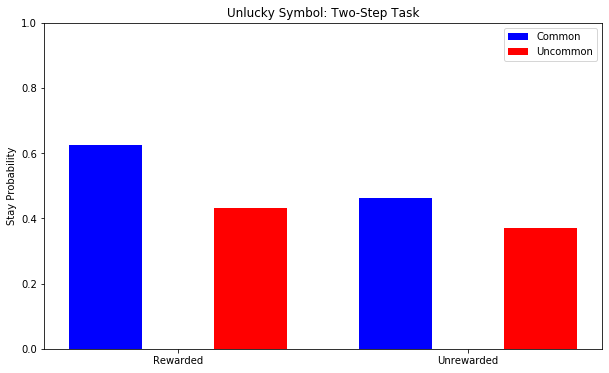

In [476]:
agents.plot()

In [579]:
# Model-Based Strategy

class model_based(object):
    def __init__(self, trials, Rs, a, b):
        
        self.n_trials = trials
 
        self.R = Rs
        self.state = SA
        
        # define parameters
        self.alpha = a
        self.beta = b
        
        # define values
        self.MB = np.zeros((2, 2))
        
        self.rewards = np.zeros(trials)
        self.choices = np.zeros((trials, 2))
        self.choice1_outcomes = np.zeros(trials)
        self.switch = np.zeros(trials)
        self.common = np.zeros(trials)
        
        self.transitions = np.array([
            [0.7, 0.3],
            [0.3, 0.7]
        ])
        
        self.transition_count = np.zeros((2,2,2))
        self.final_state = np.zeros(trials) # 1 = SB, 2 = SC
        
    def possible_switch(self, choice):
        if random.random() < 0.7:
            return choice
        return 1 - choice
    
    def update_stay_prob(self, action, t):
        self.transition_count[
            int(not self.rewards[t-1]),
            int(not self.common[t-1]),
            int(not (self.choice1_outcomes[t-1] == action))
        ] += 1
        
    def compute_stay_prob(self, transition_count):
        # stay_prob[r,c,a] = P[r,c,a] / (P[r,c,a] + P[r,c,~a]) 
        action_count = transition_count.sum(axis=-1)
        return transition_count / action_count[:, :, np.newaxis]

    def train(self, R):
        
        for t in range(self.n_trials):
            
            self.state = SA
            
            ## Action selection.
            d1 = 0.3*(max(self.MB[1]) - max(self.MB[0]))
            
            # choice probabilities and making choice
            theta1 = inv_logit( self.beta * d1 )
            choice1 = np.random.binomial(1, theta1)
            self.choices[t,0] = choice1
            
            # observe outcome and possible switch
            outcome1 = possible_switch(choice1)
            self.choice1_outcomes[t] = outcome1
            
            # update values for stay_probs
            if t > 0:    
                self.update_stay_prob(outcome1, t)
            
            reward_probs = None
            # update state
            if self.choice1_outcomes[t] == 0: # went LEFT
                self.state = SB
                self.final_state[t] = 1
                reward_probs = self.R[t][0:2]
            else: # went RIGHT
                self.state = SC
                self.final_state[t] = 2
                reward_probs = self.R[t][2:4]
            
            # count possible switch
            if (self.choices[t,0] == 1 & self.state == SB) | (self.choices[t,0] == 0 & self.state == SC):
                self.switch[t] = 1
            else:
                self.common[t] = 1
            
            # make second-level choice
            d2 = self.MB[outcome1,1] - self.MB[outcome1,0]

            theta2 = inv_logit( self.beta * d2 )
            choice2 = np.random.binomial(1, theta2)
            self.choices[t,1] = choice2
            
            # get what the reward is
            final_prob = reward_probs[choice2]
            reward = np.random.binomial(1, final_prob)
            self.rewards[t] = reward
            
            # update values
            self.MB[outcome1, choice2] = (1-self.alpha)*self.MB[outcome1, choice2] + self.alpha*self.rewards[t]

            
    def plot(self, transition_count=None, title="Model-Based Two-Step Task", y_lim=0.5):
        _,ax = plt.subplots(1,1,figsize=[10,6])

        ax.set_ylim([y_lim, 1.0])
        ax.set_ylabel('Stay Probability')
        ax.set_title(title)

        if transition_count is None:
            transition_count = self.transition_count
        
        stay_probs = self.compute_stay_prob(transition_count)
        
        common = [stay_probs[0,0,0], stay_probs[1,0,0]]
        uncommon = [stay_probs[0,1,0], stay_probs[1,1,0]]
        
        ax.set_xticks([1.5,3.5])
        ax.set_xticklabels(['Rewarded', 'Unrewarded'])
        ax.set_ylim(0,1)
        
        c = plt.bar([1,3], common, color='b', width=0.5)
        uc = plt.bar([2,4], uncommon, color='r', width=0.5)
        ax.legend( (c[0], uc[0]), ('Common', 'Uncommon') )



In [580]:
n_agents = 1
trials = 400
alpha = 0.5
beta = 10.00

In [581]:
np.random.seed(11408)
agents_MB = model_based(trials, Rs, alpha, beta)

In [582]:
MBtrained = agents_MB.train(Rs)

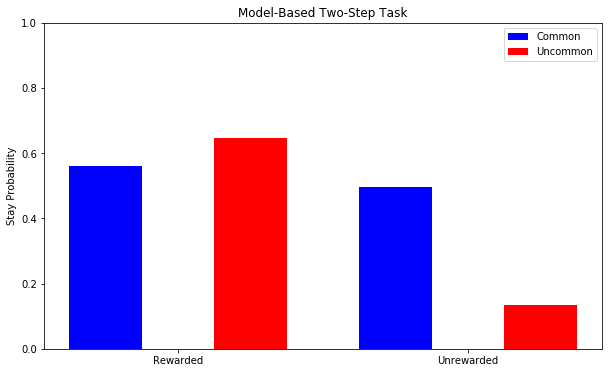

In [583]:
agents_MB.plot()

In [420]:
# THIS IS WRONG!! —— something wrong here with the way that you are coding the task . . . 

In [410]:
# would this be better if we used two betas, one for each stage, like Daw and Toyama did?
# is this the right way to calculate Stay Probabilities? This seems low when you look at the graph . . . 